In [32]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from pydantic import BaseModel, Field, field_validator


In [2]:
class QuadState(TypedDict):
    a: int
    b: int
    c: int

    equation: str
    discriminant: float
    result: str



In [3]:
def show_equation(state):
    equation = f'{state["a"]}x2{state["b"]}x{state["c"]}'

    return {'equation': equation}

In [4]:
def calculate_discriminant(state):
    discriminant = state['b']**2 - (4*state['a']*state['c'])

    return {'discriminant': discriminant}

In [5]:
def real_roots(state):
    root1 = (-state['b'] + state['discriminant']**0.5) / (2*state['a'])
    root2 = (-state['b'] - state['discriminant']**0.5) / (2*state['a'])
 
    result = f"The roots are {root1} and {root2}"

    return {'result': result}

def repeated_roots(state):
    root = (-state['b']  / (2*state['a']))
 
    result = f"Only repeating root is {root}"

    return {'result': result}


def no_real_roots(state): 
    result = f"No real roots"

    return {'result': result}


def check_condition(state):
    if state['discriminant'] > 0:
        return "real_roots"
    elif state['discriminant'] == 0:
        return "repeated_roots"
    else:
        return "no_real_roots"

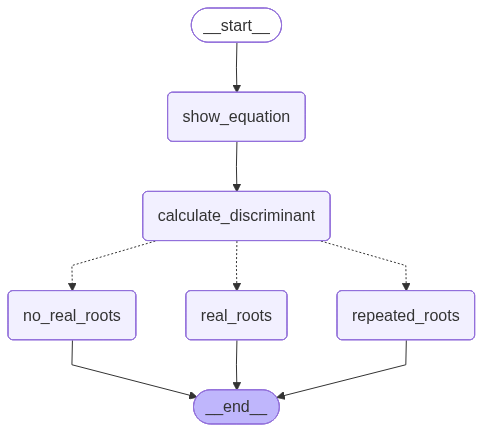

In [6]:
graph = StateGraph(QuadState)
graph.add_node('show_equation', show_equation)                                    
graph.add_node('calculate_discriminant', calculate_discriminant)  
graph.add_node('real_roots', real_roots)  
graph.add_node('repeated_roots', repeated_roots)  
graph.add_node('no_real_roots', no_real_roots)  

graph.add_edge(START, 'show_equation')
graph.add_edge('show_equation', 'calculate_discriminant')

graph.add_conditional_edges('calculate_discriminant', check_condition,{
    "real_roots": "real_roots",
    "repeated_roots": "repeated_roots",
    "no_real_roots": "no_real_roots"})

graph.add_edge('real_roots', END)
graph.add_edge('repeated_roots', END)
graph.add_edge('no_real_roots', END)


workflow = graph.compile()
workflow

In [7]:
initial_state = {
    'a': 4,
    'b': 2,
    'c': 2,
    }
workflow.invoke(initial_state)

{'a': 4,
 'b': 2,
 'c': 2,
 'equation': '4x22x2',
 'discriminant': -28,
 'result': 'No real roots'}

USING LLM

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os
load_dotenv()
key = os.environ.get('')


In [28]:
LLM = ChatOpenAI(
    model="nex-agi/deepseek-v3.1-nex-n1:free",
    api_key=os.environ.get('OPEN_ROUTER_API_KEY'),
    base_url="https://openrouter.ai/api/v1",
)

In [33]:

class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(
        description="sentiment of the review"
    )

    @field_validator("sentiment", mode="before")
    @classmethod
    def case_insensitive_sentiment(cls, v):
        if isinstance(v, str):
            return v.lower()
        return v

In [34]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"]
    tone: Literal["angry", "frustrated", "disappointed", "calm"]
    urgency: Literal["low", "medium", "high"]

    @field_validator("issue_type", mode="before")
    @classmethod
    def normalize_issue_type(cls, v):
        if isinstance(v, str):
            v = v.strip().lower()
            mapping = {
                "ux": "UX",
                "performance": "Performance",
                "bug": "Bug",
                "support": "Support",
                "other": "Other",
                "authentication_failure": "Bug",
                "login_issue": "Bug",
            }
            return mapping.get(v, "Other")
        return v

    @field_validator("tone", mode="before")
    @classmethod
    def normalize_tone(cls, v):
        if isinstance(v, str):
            return v.lower()
        return v

    @field_validator("urgency", mode="before")
    @classmethod
    def normalize_urgency(cls, v):
        if isinstance(v, str):
            return v.lower()
        return v


In [35]:
structured_model = LLM.with_structured_output(SentimentSchema)
structured_model2 = LLM.with_structured_output(DiagnosisSchema)

In [36]:
prompt = "What is sentiment od the following review - The product was very good"
structured_model.invoke(prompt).sentiment

'positive'

In [37]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [38]:
def find_sentiment(state):
    prompt = f'''For the following review find out the sentiment Return ONLY lowercase JSON.
Allowed values: "positive" or "negative".\n {state["review"]}'''
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state):
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state):
    prompt = f"write a warm thank you message in response to this review: \n {state['review']}"
    response = LLM.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state):
    prompt = prompt = f"""
        Diagnose the following negative review.

        Review:
        {state['review']}

        Return ONLY valid JSON with:
        - issue_type
        - tone
        - urgency
        """

    response = structured_model2.invoke(prompt)
    return {'diagnosis': response.model_dump()}  


def negative_response(state):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = LLM.invoke(prompt)
    return {'response': response}

    

In [39]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)


graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment,
                            {
                                'positive_response': 'positive_response',
                                'run_diagnosis': 'run_diagnosis'
                                }
                                )
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)


workflow = graph.compile()


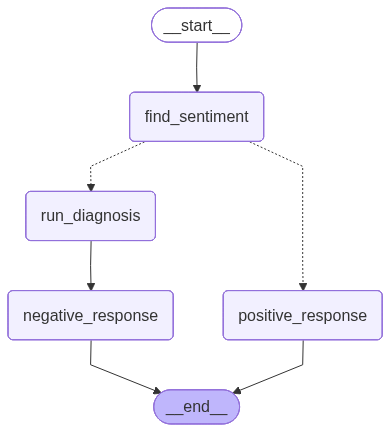

In [40]:
workflow

In [41]:
initial_state = {'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.'}
workflow.invoke(initial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'UX', 'tone': 'frustrated', 'urgency': 'high'},
 'response': AIMessage(content="I understand you're experiencing a UX issue and I can hear the frustration in your request. When something isn't working smoothly or feels confusing, it can definitely be frustrating—especially when you need to get things done. I want to help resolve this for you as quickly as possible.\n\nTo provide you with the most effective solution, could you share a few more details about what you're experiencing? For example:\n- Is this happening in a specific application, website, or tool?\n- What exactly is the UX issue you're encountering (e.g., can't find a feature, confusing navigation, broken functionality)?\n- Are y